/tmp/ipykernel_2025865/3191185969.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  autumn = plt.cm.get_cmap('autumn')


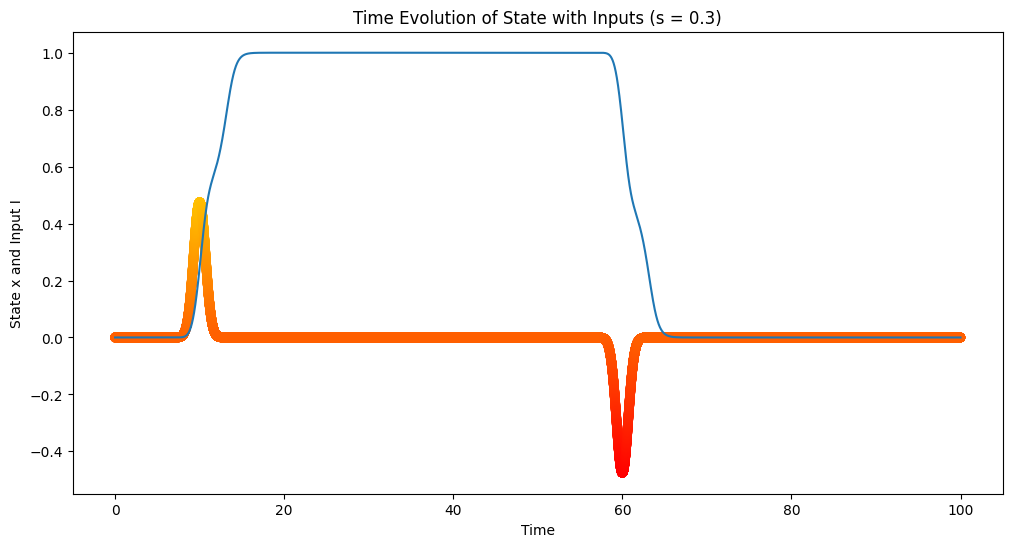

/tmp/ipykernel_2025865/3191185969.py:196: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter_unstable = ax.scatter(unstable_fp_I, unstable_fp_x, c=unstable_fp_I, marker='x', cmap=cmap, s=40, edgecolors='k', facecolors='none', label='Unstable Fixed Points')


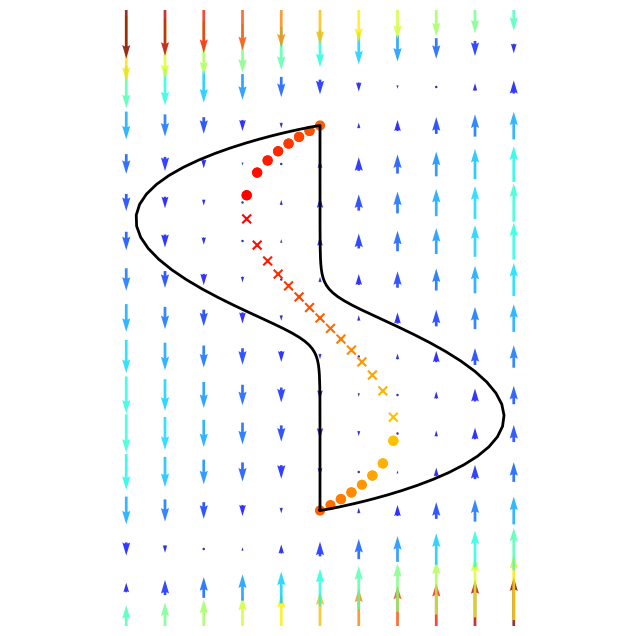

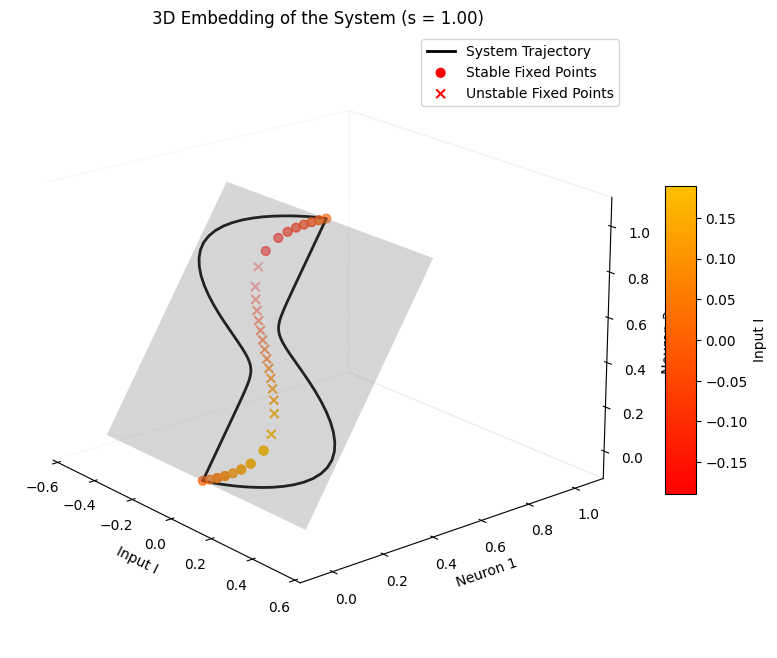

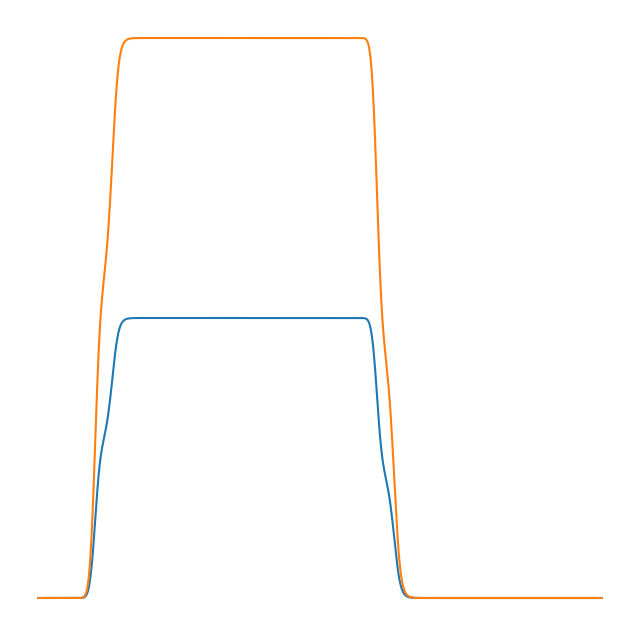

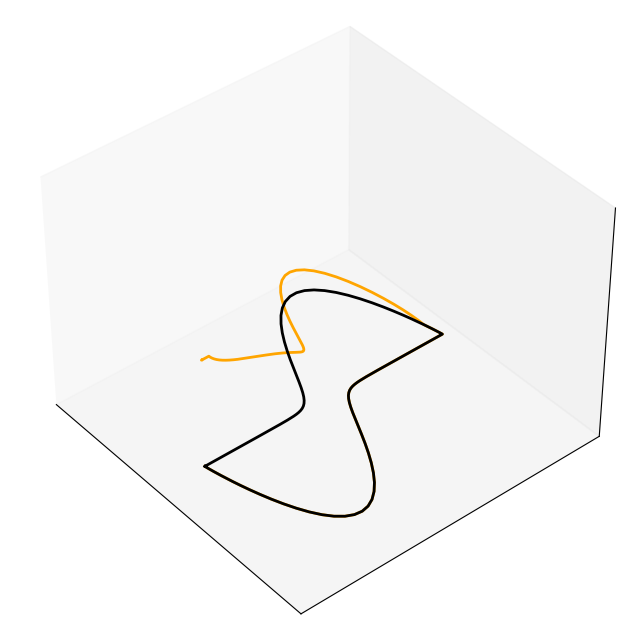

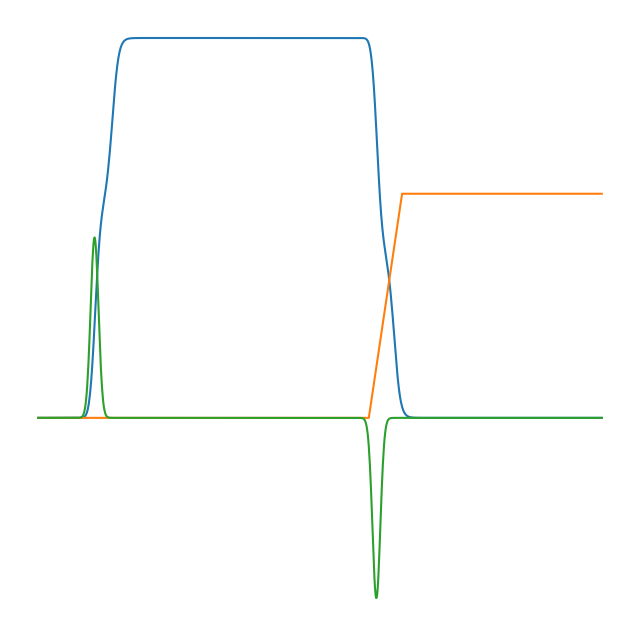

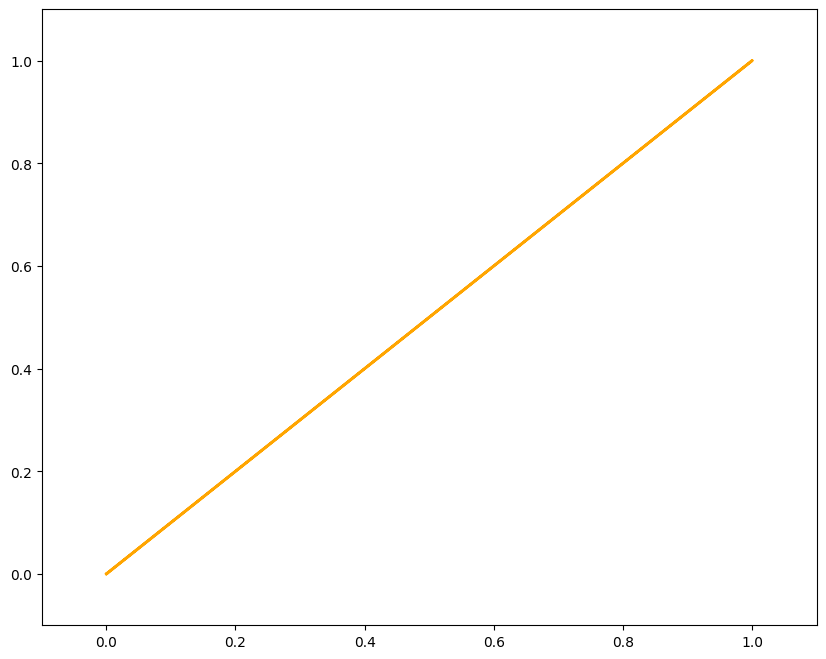

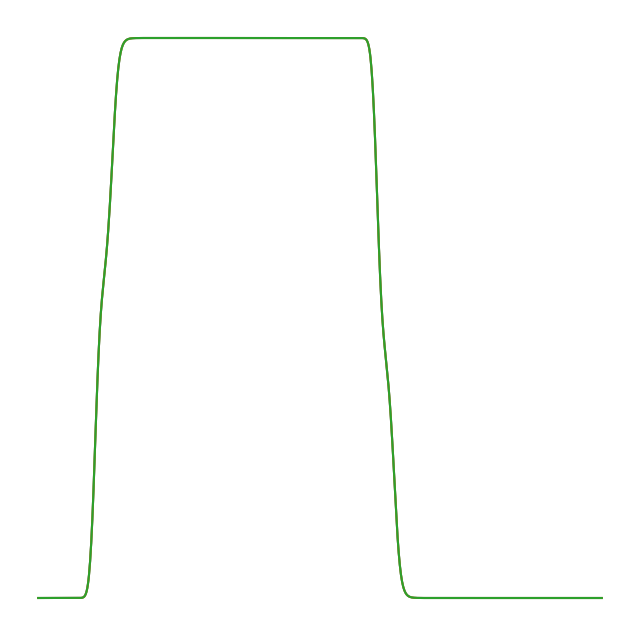

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap


cmap = "inferno"
# Get the original 'autumn' colormap
autumn = plt.cm.get_cmap('autumn')

# Create a new colormap by trimming the range of the autumn colormap
# Adjusting the start and stop values trims off the yellow part
colors = autumn(np.linspace(0, 0.75, 256))  # Use values up to 0.85 to reduce yellow

# Create a new colormap with the adjusted range
custom_autumn = LinearSegmentedColormap.from_list('custom_autumn', colors)
cmap = custom_autumn

# Modified system equation with sensitivity parameter s
def system(x, t, I_func, s):
    I = I_func(t)
    dU_dx = 2 * x - 6 * x**2 + 4 * x**3
    dxdt = -s * dU_dx + I
    return dxdt

# Input function with reduced amplitudes
def I_func(t):
    # Parameters for the positive Gaussian pulse
    A_pos = 0.475      # Reduced amplitude of positive pulse
    t_pos = 10.0      # Center time of positive pulse
    sigma_pos = 0.7  # Width of positive pulse

    # Parameters for the negative Gaussian pulse
    A_neg = -0.475     # Reduced amplitude of negative pulse
    t_neg = 60.0     # Center time of negative pulse
    sigma_neg = 0.7  # Width of negative pulse

    # Parameters for the ineffective Gaussian pulse
    A_pos_null = 0.48      # Reduced amplitude of ineffective positive pulse
    t_pos_null = 30.0     # Center time of ineffective positive pulse
    sigma_pos_null = 0.9  # Width of ineffective positive pulse



    # Parameters for the ineffective negative Gaussian pulse
    A_neg_null = -0.48     # Reduced amplitude of ineffective negative pulse
    t_neg_null = 80.0     # Center time of ineffective negative pulse
    sigma_neg_null = 0.5  # Width of ineffective negative pulse

    # Positive Gaussian pulse
    I_pos = A_pos * np.exp(-((t - t_pos) ** 2) / (2 * sigma_pos ** 2))

    # Negative Gaussian pulse
    I_neg = A_neg * np.exp(-((t - t_neg) ** 2) / (2 * sigma_neg ** 2))

    # Ineffective positive Gaussian pulse (commented out in total input)
    I_pos_null = A_pos_null * np.exp(-((t - t_pos_null) ** 2) / (2 * sigma_pos_null ** 2))


    # Ineffective negative Gaussian pulse (commented out in total input)
    I_neg_null = A_neg_null * np.exp(-((t - t_neg_null) ** 2) / (2 * sigma_neg_null ** 2))

    # Total input (currently only effective pulses)
    I_t = I_pos + I_neg  # + I_pos_null + I_neg_null
    return I_t

# Time vector
t = np.linspace(0, 100, 50000)
solver_options = {'rtol': 1e-10, 'atol': 1e-12}

# Initial condition
x0 = 0.0

# Sensitivity parameter
s = 1.0  # Smaller s makes the system more sensitive

# Solving the ODE with the modified system equation
x = odeint(system, x0, t, args=(I_func, s), **solver_options).flatten()

# Input values over time
I_over_time = np.array([I_func(ti) for ti in t])

# Time evolution plot
fig0 = plt.figure(figsize=(12, 6))
ax0 = fig0.add_subplot(111)
ax0.plot(t, x, label='State x(t)')
ax0.scatter(t, I_over_time,c = I_over_time, label='Input I(t)',cmap = cmap, linestyle='-')
ax0.set_xlabel('Time')
ax0.set_ylabel('State x and Input I')
ax0.set_title('Time Evolution of State with Inputs (s = 0.3)')

fig0.savefig('inputs_1BFF.pdf')
plt.show()

# Range of x and I values
stepX = 0.1  # Smaller step for smoother curves
x_vals = np.arange(-0.3, 1.3 + stepX, stepX)
I_vals = np.arange(-0.5, 0.5 + stepX, stepX)

# Round values to nearest 0.001
# x_vals = np.round(x_vals, 3)
# I_vals = np.round(I_vals, 3)

X, I_grid = np.meshgrid(x_vals, I_vals)

# Compute the derivative of U(x)
dU_dx = 2 * X - 6 * X**2 + 4 * X**3

# Compute dx/dt for the grid with sensitivity parameter
dXdt = -s * dU_dx + I_grid

# Since I is not dynamic, its derivative is zero
dIdt = np.zeros_like(dXdt)

# Normalizing the vectors for better visualization
# M = np.abs(dXdt)
# M[M == 0] = 1  # Avoid division by zero
# dXdt_norm = dXdt / M
dXdt_norm = dXdt

# # Round down the values to zero if they are very small
# dXdt_norm[np.abs(dXdt_norm) < 1e-3] = 0

# Function to compute fixed points for a given I
def fixed_points(I, s):
    # Function to find roots
    def func(x):
        return s * (2 * x - 6 * x**2 + 4 * x**3) - I
    guesses = [-0.5,0.0, 0.5, 1.0, 1.5]
    roots = []
    for guess in guesses:
        root, info, ier, mesg = fsolve(func, guess, full_output=True)
        if ier == 1 and 0.0 <= root[0] <= 1.0:
            roots.append(root[0])
    return np.unique(roots)

# Compute fixed points over a range of I values
I_values = np.linspace(-1.0, 1.0, 75)
stable_fp_x = []
stable_fp_I = []
unstable_fp_x = []
unstable_fp_I = []

for I_val in I_values:
    x_fps = fixed_points(I_val, s)
    for x_fp in x_fps:
        # Compute second derivative of U(x) at x_fp
        d2U_dx2 = 2 - 12 * x_fp + 12 * x_fp**2
        # Compute the eigenvalue (lambda)
        lambda_ = -s * d2U_dx2
        if lambda_ > 0:
            # Unstable fixed point
            unstable_fp_x.append(x_fp)
            unstable_fp_I.append(I_val)
        else:
            # Stable fixed point
            stable_fp_x.append(x_fp)
            stable_fp_I.append(I_val)

# Plotting the corrected flow field
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.quiver(I_grid, X,  np.zeros_like(dXdt_norm), dXdt_norm, M, pivot='mid', cmap='jet', alpha=0.8)
# ax.set_xlabel('State x')
# ax.set_ylabel('Input I')
# ax.set_title(f'Dynamical Flow Field (s = {s:.2f})')

# Plotting the system trajectory
from scipy.interpolate import interp1d

# Create interpolation functions
x_interp = interp1d(t, x, kind='linear')
I_interp = interp1d(t, I_over_time, kind='linear')

# Time points for interpolation
t_fine = np.linspace(0, 100, 1000)
x_fine = x_interp(t_fine)
I_fine = I_interp(t_fine)

# Plotting the trajectory
ax.plot(I_fine, x_fine, 'k-', linewidth=2, label='System Trajectory')

# Highlighting the bit turning on and off
on_pulse_idx = (t_fine >= 5) & (t_fine <= 25)
off_pulse_idx = (t_fine >= 55) & (t_fine <= 75)
# ax.plot(I_fine[on_pulse_idx], x_fine[on_pulse_idx], 'g-', linewidth=2, label='Bit Turning On')
# ax.plot(I_fine[off_pulse_idx], x_fine[off_pulse_idx], 'r-', linewidth=2, label='Bit Turning Off')

# Plotting the fixed points with colors according to I
# For stable fixed points
scatter_stable = ax.scatter(stable_fp_I, stable_fp_x, c=stable_fp_I, cmap=cmap, s=40, label='Stable Fixed Points')

# For unstable fixed points
scatter_unstable = ax.scatter(unstable_fp_I, unstable_fp_x, c=unstable_fp_I, marker='x', cmap=cmap, s=40, edgecolors='k', facecolors='none', label='Unstable Fixed Points')

# Adjusting plot aesthetics
ax.set_xlim(-.8, .8)
ax.set_ylim(-0.3, 1.3)
# ax.legend(loc='upper right')
ax.grid(False)

# Remove spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

fig.savefig('dynamical_flow_field.pdf')
plt.show()


# Plotting the 3D embedding of the system
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Prepare the state projections
# We'll define a simple projection function for the state
def project_state(state):
    # Simple linear embedding: map x into y and z linearly
    n1 = state/2
    n2 = state
    return n1, n2

# Create interpolation functions
from scipy.interpolate import interp1d
x_interp = interp1d(t, x, kind='linear')
I_interp = interp1d(t, I_over_time, kind='linear')

# Time points for interpolation
t_fine = np.linspace(0, 100, 1000)
x_fine = x_interp(t_fine)
I_fine = I_interp(t_fine)

# Project the state variable
n1_fine, n2_fine = project_state(x_fine)

# Plot the system trajectory in 3D
ax.plot(I_fine, n1_fine, n2_fine, 'k-', linewidth=2, label='System Trajectory')

# Plotting the fixed points in 3D
stable_n1, stable_n2 = project_state(np.array(stable_fp_x))
unstable_n1, unstable_n2 = project_state(np.array(unstable_fp_x))

# Stable fixed points
sc_stable = ax.scatter(stable_fp_I, stable_n1, stable_n2, c=stable_fp_I, cmap=cmap, s=40, label='Stable Fixed Points')

# Unstable fixed points
sc_unstable = ax.scatter(unstable_fp_I, unstable_n1, unstable_n2, c=unstable_fp_I, cmap=cmap, s=40, marker='x', label='Unstable Fixed Points')

# Customize the axes labels
ax.set_xlabel('Input I')
ax.set_ylabel('Neuron 1')
ax.set_zlabel('Neuron 2')
ax.set_title('3D Embedding of the System (s = {:.2f})'.format(s))

# Add a colorbar
cbar = fig.colorbar(sc_stable, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Input I')

# Adjust view angle for better visualization
ax.view_init(elev=20, azim=-40)

# Remove gridlines and axes panes for a cleaner look
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_xlim(-.6, .6)
ax.set_ylim(-0.1, 1.1)
ax.set_zlim(-0.1, 1.1)

# set axes equal to avoid distortion
# ax.set_xlim()
# Add a grey plane where the projections live (e.g., z = y plane)
min_n1 = np.min(n1_fine)
max_n1 = np.max(n1_fine)
min_n2 = np.min(n2_fine)
max_n2 = np.max(n2_fine)

x_plane = np.linspace(-0.5, 0.5, 100)
y_plane = np.linspace(min_n1, max_n1, 100)


X_plane, Y_plane = np.meshgrid(x_plane, y_plane)
Z_plane = Y_plane*2  # Since in linear embedding, z = y

# Plot the plane
ax.plot_surface(X_plane, Y_plane, Z_plane, color='grey', alpha=0.3)

ax.legend()
fig.savefig('3d_embedding.pdf')
plt.show()

fig = plt.figure(figsize=(8, 8))
# Plot the neuron firing rates over time

ax = fig.add_subplot(111)
ax.plot( n1_fine, label='Neuron 1')
ax.plot( n2_fine, label='Neuron 2')
# ax.plot(I_fine)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('neuron_firing_rates.pdf')



# Plotting the system when it adds additional features
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Prepare the state projections
def extra_features(x_fine):
    x_fine_extra = np.zeros_like(x_fine)
    dif_x_fine = np.abs(np.gradient(x_fine))>0.01

    x_fine_extra = 0.005*np.cumsum(dif_x_fine)

    return x_fine, x_fine_extra

def extra_features2(x_fine):
    x_fine_extra = np.zeros_like(x_fine)
    dif_x_fine = np.abs(np.gradient(x_fine))>0.005


    dif_x_fine[:500] = 0

    x_fine_extra = 0.01*np.cumsum(dif_x_fine)
    return x_fine, x_fine_extra

# Create interpolation functions
from scipy.interpolate import interp1d
x_interp = interp1d(t, x, kind='linear')
I_interp = interp1d(t, I_over_time, kind='linear')

# Time points for interpolation
t_fine = np.linspace(0, 100, 1000)
x_fine = x_interp(t_fine)
I_fine = I_interp(t_fine)

# Project the state variable
n1_fine, n2_fine = extra_features2(x_fine)

# Plot the system trajectory in 3D
ax.plot(I_fine, n1_fine, n2_fine, '-', color = 'orange', linewidth=2, label='System Trajectory')

ax.plot(I_fine, n1_fine, np.zeros_like(n2_fine), 'k-', linewidth=2, label='System Trajectory')

# # Stable fixed points
# sc_stable = ax.scatter(stable_fp_I, stable_n1, stable_n2, c=stable_fp_I, cmap=cmap, s=40, label='Stable Fixed Points')

# # Unstable fixed points
# sc_unstable = ax.scatter(unstable_fp_I, unstable_n1, unstable_n2, c=unstable_fp_I, cmap=cmap, s=40, marker='x', label='Unstable Fixed Points')
ax.set_xlim(-.6, .6)
ax.set_ylim(-0.1, 1.1)
ax.set_zlim(-0.1, 1.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Set view
ax.view_init(elev=40, azim=-40)

fig.savefig('3d_embedding_extra_features.pdf')

fig = plt.figure(figsize=(8, 8))
# plot the extra features and inputs over time

ax = fig.add_subplot(111)
ax.plot( n1_fine, label='Neuron 1')
ax.plot( n2_fine, label='Neuron 2')
ax.plot(I_fine, label='Input I')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('neuron_firing_rates_extra_features.pdf')



# Plotting the system when it adds additional features
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Create interpolation functions
from scipy.interpolate import interp1d
x_interp = interp1d(t, x, kind='linear')
I_interp = interp1d(t, x, kind='linear')

# Time points for interpolation
t_fine = np.linspace(0, 100, 1000)
x_fine = x_interp(t_fine)
I_fine = I_interp(t_fine)



# Project the state variable
n1_fine = x_fine
n2_fine = x_fine

# Plot the system trajectory in 3D
ax.plot(I_fine, n1_fine, '-', color = 'orange', linewidth=2, label='System Trajectory')

# # Stable fixed points
# sc_stable = ax.scatter(stable_fp_I, stable_n1, stable_n2, c=stable_fp_I, cmap=cmap, s=40, label='Stable Fixed Points')

# # Unstable fixed points
# sc_unstable = ax.scatter(unstable_fp_I, unstable_n1, unstable_n2, c=unstable_fp_I, cmap=cmap, s=40, marker='x', label='Unstable Fixed Points')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.set_xticks([])
# ax.set_yticks([])

fig.savefig('2d_dynamical_mis.pdf')


fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)
ax.plot( x_fine, label='Neuron 1')
ax.plot( n2_fine, label='Neuron 2')
ax.plot(I_fine, label='Input I')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('neuron_firing_rates_2d_mis.pdf')


/tmp/ipykernel_2024827/876797371.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  autumn = plt.cm.get_cmap('autumn')


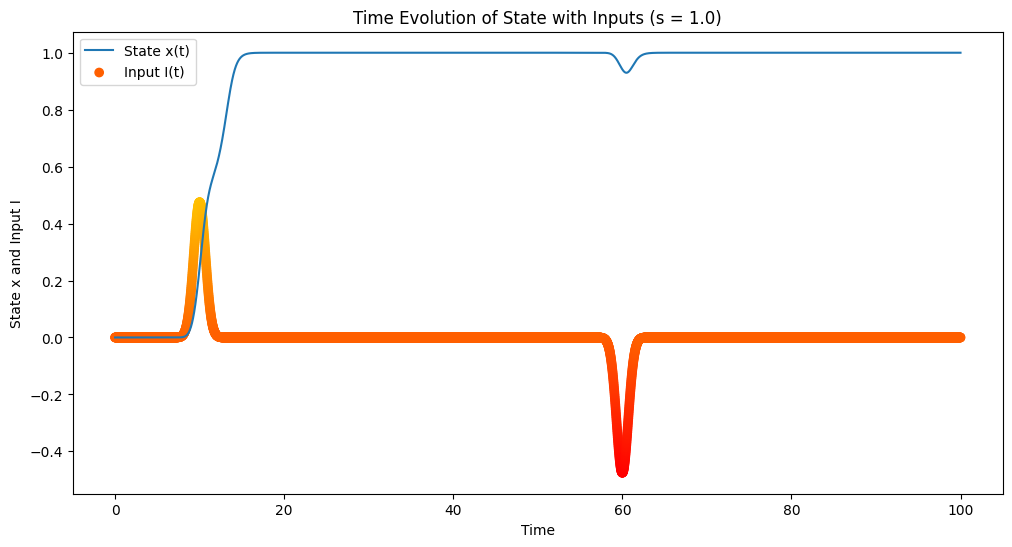

/tmp/ipykernel_2024827/876797371.py:147: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter_unstable = ax.scatter(unstable_fp_I, unstable_fp_x, c=unstable_fp_I, marker='x', cmap=cmap, s=40, edgecolors='k', facecolors='none', label='Unstable Fixed Points')


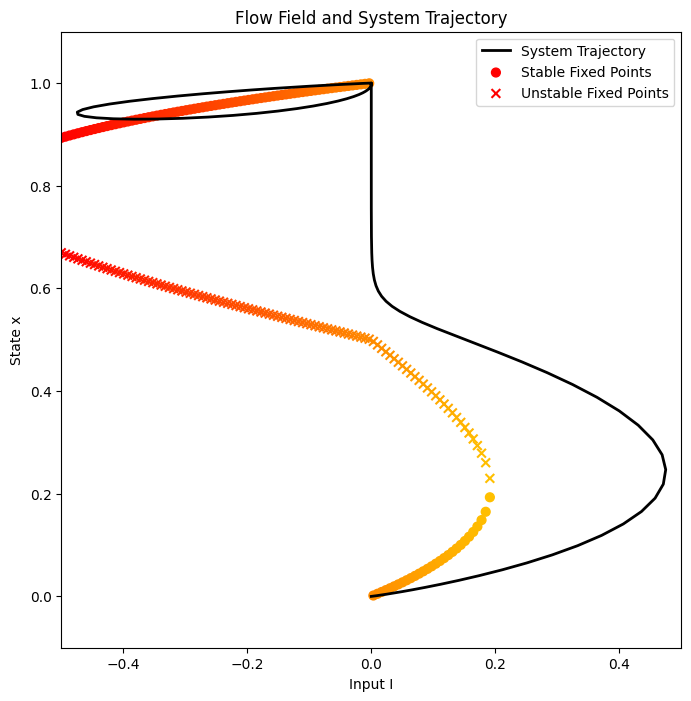

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap setup
autumn = plt.cm.get_cmap('autumn')
colors = autumn(np.linspace(0, 0.75, 256))
custom_autumn = LinearSegmentedColormap.from_list('custom_autumn', colors)
cmap = custom_autumn

# Modified system equation with sensitivity parameter s
def system(x, t, I_func, s):
    I = I_func(t)
    # Reduce the effect of negative inputs
    if I < 0:
        I = 0.3 * I
    # Consistent derivative of U(x)
    dU_dx = 2 * x - 6 * x**2 + 4 * x**3
    dxdt = -s * dU_dx + I
    return dxdt

# Input function with original amplitudes
def I_func(t):
    # Parameters for the positive Gaussian pulse
    A_pos = 0.475     # Amplitude of positive pulse
    t_pos = 10.0      # Center time of positive pulse
    sigma_pos = 0.7   # Width of positive pulse

    # Parameters for the negative Gaussian pulse
    A_neg = -0.475    # Amplitude of negative pulse
    t_neg = 60.0      # Center time of negative pulse
    sigma_neg = 0.7   # Width of negative pulse

    # Positive Gaussian pulse
    I_pos = A_pos * np.exp(-((t - t_pos) ** 2) / (2 * sigma_pos ** 2))

    # Negative Gaussian pulse
    I_neg = A_neg * np.exp(-((t - t_neg) ** 2) / (2 * sigma_neg ** 2))

    # Total input
    I_t = I_pos + I_neg
    return I_t

# Time vector
t = np.linspace(0, 100, 5000)
solver_options = {'rtol': 1e-10, 'atol': 1e-12}

# Initial condition
x0 = 0.0

# Sensitivity parameter
s = 1.0  # Sensitivity of the system

# Solving the ODE with the modified system equation
x = odeint(system, x0, t, args=(I_func, s), **solver_options).flatten()

# Input values over time
I_over_time = np.array([I_func(ti) for ti in t])

# Time evolution plot
fig0 = plt.figure(figsize=(12, 6))
ax0 = fig0.add_subplot(111)
ax0.plot(t, x, label='State x(t)')
ax0.scatter(t, I_over_time, c=I_over_time, cmap=cmap, label='Input I(t)')
ax0.set_xlabel('Time')
ax0.set_ylabel('State x and Input I')
ax0.set_title('Time Evolution of State with Inputs (s = 1.0)')
ax0.legend()
fig0.savefig('inputs_modified.pdf')
plt.show()

# Range of x and I values
stepX = 0.05  # Smaller step for smoother curves
x_vals = np.arange(-0.3, 1.3 + stepX, stepX)
I_vals = np.arange(-0.5, 0.5 + stepX, stepX)
X, I_grid = np.meshgrid(x_vals, I_vals)

# Adjust I_grid for negative inputs as in the system
adjusted_I_grid = np.copy(I_grid)
adjusted_I_grid[adjusted_I_grid < 0] = 0.1 * adjusted_I_grid[adjusted_I_grid < 0]

# Compute the derivative of U(x)
dU_dx = 2 * X - 6 * X**2 + 4 * X**3  # Consistent dU/dx

# Compute dx/dt for the grid with sensitivity parameter
dXdt = -s * dU_dx + adjusted_I_grid

# Function to compute fixed points for a given I
def fixed_points(I, s):
    # Adjust I as in the system
    adjusted_I = I
    if I < 0:
        adjusted_I = 0.3 * I

    def func(x):
        return s * (2 * x - 6 * x**2 + 4 * x**3) - adjusted_I
    guesses = [0.0, 0.5, 1.0]
    roots = []
    for guess in guesses:
        root, info, ier, mesg = fsolve(func, guess, full_output=True)
        if ier == 1 and 0.0 <= root[0] <= 1.0:
            roots.append(root[0])
    return np.unique(roots)

# Compute fixed points over a range of I values
I_values = np.linspace(-0.5, 0.5, 150)
stable_fp_x = []
stable_fp_I = []
unstable_fp_x = []
unstable_fp_I = []

for I_val in I_values:
    x_fps = fixed_points(I_val, s)
    for x_fp in x_fps:
        # Compute second derivative of U(x) at x_fp
        d2U_dx2 = 2 - 12 * x_fp + 12 * x_fp**2  # Consistent d2U/dx2
        # Compute the eigenvalue (lambda)
        lambda_ = -s * d2U_dx2
        if lambda_ > 0:
            # Unstable fixed point
            unstable_fp_x.append(x_fp)
            unstable_fp_I.append(I_val)
        else:
            # Stable fixed point
            stable_fp_x.append(x_fp)
            stable_fp_I.append(I_val)

# Plotting the flow field and system trajectory
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotting the system trajectory
from scipy.interpolate import interp1d
x_interp = interp1d(t, x, kind='linear')
I_interp = interp1d(t, I_over_time, kind='linear')
t_fine = np.linspace(0, 100, 1000)
x_fine = x_interp(t_fine)
I_fine = I_interp(t_fine)
ax.plot(I_fine, x_fine, 'k-', linewidth=2, label='System Trajectory')

# Plotting the fixed points with colors according to I
# For stable fixed points
scatter_stable = ax.scatter(stable_fp_I, stable_fp_x, c=stable_fp_I, cmap=cmap, s=40, label='Stable Fixed Points')
# For unstable fixed points
scatter_unstable = ax.scatter(unstable_fp_I, unstable_fp_x, c=unstable_fp_I, marker='x', cmap=cmap, s=40, edgecolors='k', facecolors='none', label='Unstable Fixed Points')

# Adjusting plot aesthetics
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(False)
ax.legend()
ax.set_xlabel('Input I')
ax.set_ylabel('State x')
ax.set_title('Flow Field and System Trajectory')
fig.savefig('dynamical_flow_field_modified.pdf')
plt.show()


Animating frame 1/500
Animating frame 2/500
Animating frame 3/500
Animating frame 4/500
Animating frame 5/500
Animating frame 6/500
Animating frame 7/500
Animating frame 8/500
Animating frame 9/500
Animating frame 10/500
Animating frame 11/500
Animating frame 12/500
Animating frame 13/500
Animating frame 14/500
Animating frame 15/500
Animating frame 16/500
Animating frame 17/500
Animating frame 18/500
Animating frame 19/500
Animating frame 20/500
Animating frame 21/500
Animating frame 22/500
Animating frame 23/500
Animating frame 24/500
Animating frame 25/500
Animating frame 26/500
Animating frame 27/500
Animating frame 28/500
Animating frame 29/500
Animating frame 30/500
Animating frame 31/500
Animating frame 32/500
Animating frame 33/500
Animating frame 34/500
Animating frame 35/500
Animating frame 36/500
Animating frame 37/500
Animating frame 38/500
Animating frame 39/500
Animating frame 40/500
Animating frame 41/500
Animating frame 42/500
Animating frame 43/500
Animating frame 44/5

KeyboardInterrupt: 

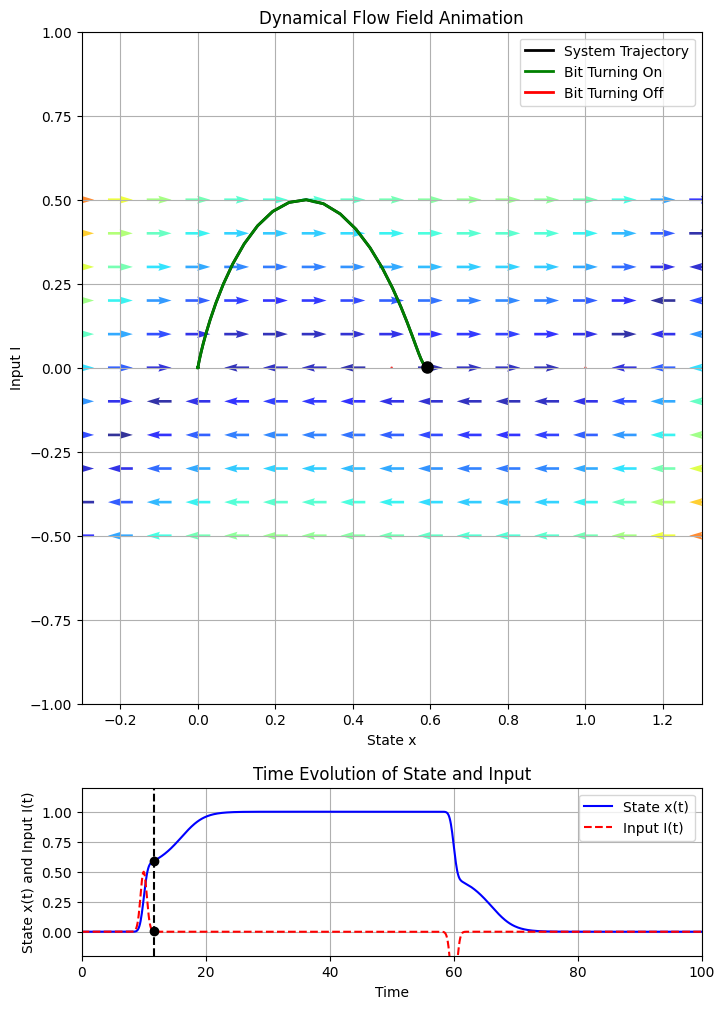

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
import matplotlib.animation as animation

# Modified system equation with sensitivity parameter s
def system(x, t, I_func, s):
    I = I_func(t)
    dU_dx = 2 * x - 6 * x**2 + 4 * x**3
    dxdt = -s * dU_dx + I
    return dxdt


# Input function with reduced amplitudes
def I_func(t):
    # Parameters for the positive Gaussian pulse
    A_pos = 0.50      # Reduced amplitude of positive pulse
    t_pos = 10.0      # Center time of positive pulse
    sigma_pos = .5  # Width of positive pulse

    # Parameters for the ineffective Gaussian pulse
    A_pos_null = 0.5      # Reduced amplitude of negative pulse
    t_pos_null = 30.0      # Center time of negative pulse
    sigma_pos_null = .5 # Width of negative pulse

    # Parameters for the negative Gaussian pulse
    A_neg = -0.5      # Reduced amplitude of negative pulse
    t_neg = 60.0      # Center time of negative pulse
    sigma_neg = .5 # Width of negative pulse

    # Parameters for the ineffective negative Gaussian pulse
    A_neg_null = -0.5      # Reduced amplitude of negative pulse
    t_neg_null = 80.0      # Center time of negative pulse
    sigma_neg_null = .5 # Width of negative pulse


    # Positive Gaussian pulse
    I_pos = A_pos * np.exp(-((t - t_pos) ** 2) / (2 * sigma_pos ** 2))

    # Ineffective positive Gaussian pulse
    I_pos_null = A_pos_null * np.exp(-((t - t_pos_null) ** 2) / (2 * sigma_pos_null ** 2))

    # Negative Gaussian pulse
    I_neg = A_neg * np.exp(-((t - t_neg) ** 2) / (2 * sigma_neg ** 2))

    # Ineffective negative Gaussian pulse
    I_neg_null = A_neg_null * np.exp(-((t - t_neg_null) ** 2) / (2 * sigma_neg_null ** 2))

    # Total input
    I_t = I_pos + I_neg #+ I_pos_null + I_neg_null
    return I_t

# Sensitivity parameter
s = 0.3  # Smaller s makes the system more sensitive

# Time vector
t = np.linspace(0, 100, 1000)

# Initial condition
x0 = 0.0

# Solving the ODE with the modified system equation
x = odeint(system, x0, t, args=(I_func, s)).flatten()

# Input values over time
I_over_time = np.array([I_func(ti) for ti in t])

# Interpolating x and I for plotting in the animation
from scipy.interpolate import interp1d
x_interp = interp1d(t, x, kind='linear')
I_interp = interp1d(t, I_over_time, kind='linear')

# Time points for the animation frames
t_anim = np.linspace(0, 100, 500)

# Range of x and I values
step_size = 0.1
x_vals = np.arange(-0.3, 1.35+step_size, step_size)
I_vals = np.arange(-0.5, 0.5 +step_size, step_size)

# Round values to nearest 0.001
x_vals = np.round(x_vals, 3)
I_vals = np.round(I_vals, 3)

X, I_grid = np.meshgrid(x_vals, I_vals)

# Compute the derivative of U(x)
dU_dx = 2 * X - 6 * X**2 + 4 * X**3

# Compute dx/dt for the grid with sensitivity parameter
dXdt = -s * dU_dx + I_grid

# Since I is not dynamic, its derivative is zero
dIdt = np.zeros_like(dXdt)

# Normalizing the vectors for better visualization
M = np.abs(dXdt)
M[M == 0] = 1  # Avoid division by zero
dXdt_norm = dXdt / M
dXdt_norm[np.abs(dXdt_norm) < 1e-3] = 0

# Set up the figure and axes for animation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12), gridspec_kw={'height_ratios': [4, 1]})

# Function to initialize the plot
def init():
    # Top panel initialization
    ax1.set_xlabel('State x')
    ax1.set_ylabel('Input I')
    ax1.set_title('Dynamical Flow Field Animation')
    ax1.set_xlim(-0.3, 1.3)
    ax1.set_ylim(-1.0, 1.0)
    ax1.grid(True)

    # Bottom panel initialization
    ax2.set_xlabel('Time')
    ax2.set_ylabel('State x(t) and Input I(t)')
    ax2.set_title('Time Evolution of State and Input')
    ax2.set_xlim(0, 100)
    ax2.set_ylim(-0.2, 1.2)
    ax2.grid(True)

    return []

# Animation function
def animate(i):
    # Clear axes to redraw
    print(f'Animating frame {i+1}/{len(t_anim)}')
    ax1.clear()
    ax2.clear()

    # Plot the flow field (static)
    ax1.quiver(X, I_grid, dXdt_norm, np.zeros_like(dXdt_norm), M, pivot='mid', cmap='jet', alpha=0.8)

    # Plot the trajectory up to the current time
    t_current = t_anim[i]
    t_traj = t[t <= t_current]
    x_traj = x[t <= t_current]
    I_traj = I_over_time[t <= t_current]
    ax1.plot(x_traj, I_traj, 'k-', linewidth=2, label='System Trajectory')

    # Highlighting the bit turning on and off
    on_pulse_idx = (t_traj >= 5 ) & (t_traj <= 25 )
    off_pulse_idx = (t_traj >= 55 ) & (t_traj <= 75)
    ax1.plot(x_traj[on_pulse_idx], I_traj[on_pulse_idx], 'g-', linewidth=2, label='Bit Turning On')
    ax1.plot(x_traj[off_pulse_idx], I_traj[off_pulse_idx], 'r-', linewidth=2, label='Bit Turning Off')

    # Plot current point
    x_current = x_interp(t_current)
    I_current = I_interp(t_current)
    ax1.plot(x_current, I_current, 'ko', markersize=8)

    # Set labels and title for top panel
    ax1.set_xlabel('State x')
    ax1.set_ylabel('Input I')
    ax1.set_title(f'Dynamical Flow Field at t = {t_current:.2f}')
    ax1.set_xlim(-0.35, 1.35)
    ax1.set_ylim(-0.6, 0.6)
    ax1.grid(True)
    ax1.legend(loc='upper right')

    # Plot the time evolution in the bottom panel
    ax2.plot(t, x, 'b-', label='State x(t)')
    ax2.plot(t, I_over_time, 'r--', label='Input I(t)')
    ax2.axvline(x=t_current, color='k', linestyle='--')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('State x(t) and Input I(t)')
    ax2.set_title('Time Evolution of State and Input')
    ax2.set_xlim(0, 100)
    ax2.set_ylim(-0.6, 1.2)
    ax2.grid(True)
    ax2.legend(loc='upper right')

    # Highlight the current time point
    ax2.plot(t_current, x_interp(t_current), 'ko')  # Current state
    ax2.plot(t_current, I_interp(t_current), 'ko')  # Current input

    return []

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=len(t_anim), init_func=init, interval=20, blit=False)

# To save the animation as a video file (e.g., MP4), uncomment the following line:
ani.save('dynamical_flow_field_with_time_evolution.mp4', writer='ffmpeg', dpi=150)

# To display the animation in a Jupyter notebook, uncomment the following lines:
# from IPython.display import HTML
# HTML(ani.to_jshtml())

# To display the animation in a window, uncomment the following line:
plt.show()
